#### NOTE: For at least the first time you run this notebook, it is required that you run the two files below to generate the needed masks and json files. If you edit either of the previously mentioned notebooks then you'll also need to run them again. Feel free to uncomment and run the lines of code below if needed.

In [1]:
# %run semantic_mask_manual.py
# %run panoptic_mask_manual.py

In [2]:
from detectron2.utils.logger import setup_logger
setup_logger()
import logging
import numpy as np
import cv2
import random
import copy
import json
import os
import pickle
import pandas as pd
from pathlib import Path
from shapely.geometry import Polygon, MultiPolygon
from PIL import Image
import matplotlib.pyplot as plt
import torch
import torchvision
import torchvision.transforms as TT
# import tensorflow as tf
# from tensorboard.plugin.hparams import api as hp
import detectron2
from detectron2 import model_zoo
from detectron2.data.datasets import register_coco_panoptic_separated, register_coco_panoptic, register_coco_instances
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.engine import DefaultTrainer, AMPTrainer, DefaultPredictor, HookBase
from detectron2.solver import build_optimizer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog, build_detection_train_loader, MapDataset, DatasetMapper, build_detection_test_loader
from detectron2.structures import BoxMode
from detectron2.modeling import build_model
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, COCOPanopticEvaluator,inference_on_dataset

In [3]:
print(torch.__version__)
print(torchvision.__version__)

2.3.1+cu121
0.18.1+cu121


In [4]:
!nvidia-smi


Tue Sep  3 14:58:26 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:65:00.0  On |                  Off |
| 30%   43C    P5             17W /   70W |    1941MiB /  12282MiB |     39%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
torch.cuda.empty_cache()

# Panoptic Segmentation via Detectron2

In [6]:
root_dir = os.path.dirname(os.path.abspath('__file__'))
data_name = 'panoptic_seg_uw'
image_root = os.path.join(root_dir, "images")
panoptic_root = os.path.join(root_dir, "panoptic_segmentation_output")
panoptic_json = os.path.join(root_dir, "panoptic_segmentation_output.json")
with open(panoptic_json) as panoptic_json_file:
    panoptic_dict = json.load(panoptic_json_file)
sem_seg_root = os.path.join(root_dir, "semantic_segmentation_output")
instances_json = panoptic_json
register_coco_panoptic_separated(data_name, {}, image_root, panoptic_root, panoptic_json, sem_seg_root, instances_json)

In [7]:
test_data_name = f"{data_name}_test"
test_image_root = os.path.join(root_dir, "test_images")
test_panoptic_root = os.path.join(root_dir, "test_panoptic_segmentation_output")
test_panoptic_json = os.path.join(root_dir, "test_panoptic_segmentation_output.json")
with open(test_panoptic_json) as test_panoptic_json_file:
    test_panoptic_dict = json.load(test_panoptic_json_file)
test_sem_seg_root = os.path.join(root_dir, "test_semantic_segmentation_output")
test_instances_json = test_panoptic_json
register_coco_panoptic_separated(test_data_name, {}, test_image_root, test_panoptic_root, test_panoptic_json, test_sem_seg_root, test_instances_json)

In [8]:
things = ['grain']
stuff = []

## Let's implement a custom DatasetMapper to apply more augmentations than what the DefaultTrainer does

In [9]:
def custom_mapper(dataset_dict):
    dataset_dict = copy.deepcopy(dataset_dict)  # it will be modified by code below
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [
        T.Resize((800,600)),
        T.RandomBrightness(0.8, 1.8),
        T.RandomContrast(0.6, 1.3),
        T.RandomSaturation(0.8, 1.4),
        T.RandomRotation(angle=[90, 90]),
        T.RandomLighting(0.7),
        T.RandomFlip(prob=0.4, horizontal=False, vertical=True),
    ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)

    # Added this conditional cuz of the weird error we were getting, seems to work, note that this won't work if the dtype is not a torch tensor
    if "sem_seg" not in dataset_dict:
        dataset_dict["sem_seg"] = torch.zeros((image.shape[0], image.shape[1]), dtype=torch.long)
    
    return dataset_dict

In [10]:
class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [11]:
torch.cuda.empty_cache()
config_file = "COCO-PanopticSegmentation/panoptic_fpn_R_50_3x.yaml"
cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.DATASETS.TRAIN = (f"{data_name}_separated",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 0
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)  
cfg.SOLVER.IMS_PER_BATCH = 7
cfg.SOLVER.MAX_ITER = 5000
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 5
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 1 
cfg.MODEL.SEM_SEG_HEAD.NUM_CLASSES = 2  # adjust this if you have stuff classes should be roi head + 1
cfg.MODEL.PANOPTIC_FPN.NUM_CLASSES = 1  # (things + stuff)
cfg.SOLVER.AMP.ENABLED = True
cfg.TEST.DETECTIONS_PER_IMAGE = 5000

# Specify learning rate
cfg.SOLVER.BASE_LR = 0.0005 
cfg.SOLVER.GAMMA = 0.25
cfg.SOLVER.STEPS = (2500,)

cfg.SOLVER.WARMUP_FACTOR = 1.0 / 1000
cfg.SOLVER.WARMUP_ITERS = 500
cfg.SOLVER.WARMUP_METHOD = "linear"

MetadataCatalog.get(cfg.DATASETS.TRAIN[0]).set(thing_classes=things, stuff_classes=stuff, thing_dataset_id_to_contiguous_id={1: 0}) 

namespace(name='panoptic_seg_uw_separated',
          panoptic_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6',
          image_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/images',
          panoptic_json='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6.json',
          sem_seg_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/semantic_segmentation_output6',
          json_file='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6.json',
          evaluator_type='coco_panoptic_seg',
          ignore_label=255,
          thing_classes=['grain'],
          stuff_classes=[],
          thing_dataset_id_to_contiguous_id={1: 0})

In [12]:
# Trying to debug CUDA OOM Error, this will track memory usage for every iteration
class MemoryTrackingHook(HookBase):
    def __init__(self, period=1):
        self.period = period

    def after_step(self):
        if self.trainer.iter % self.period == 0:
            torch.cuda.synchronize()
            max_memory = torch.cuda.max_memory_allocated() / 1024**2
            current_memory = torch.cuda.memory_allocated() / 1024**2
            self.trainer.storage.put_scalar("max_gpu_memory_mb", max_memory)
            self.trainer.storage.put_scalar("current_gpu_memory_mb", current_memory)

In [13]:
!nvidia-smi

Tue Sep  3 14:58:27 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 555.58.02              Driver Version: 555.58.02      CUDA Version: 12.5     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA RTX A2000 12GB          Off |   00000000:65:00.0  On |                  Off |
| 30%   44C    P0             22W /   70W |    1941MiB /  12282MiB |     11%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [14]:
torch.cuda.empty_cache()
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
# os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
# trainer = DefaultTrainer(cfg)
trainer = CustomTrainer(cfg)
trainer.register_hooks([MemoryTrackingHook(period=1)])
trainer.resume_or_load(resume=False)
trainer.train()

[09/03 14:58:28 d2.engine.defaults]: Model:
PanopticFPN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2): 

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (2, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (2,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (4, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (4,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (1, 256, 1, 1) in

[09/03 14:58:28 d2.engine.train_loop]: Starting training from iteration 0


/home/computational/anaconda3/lib/python3.12/site-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/home/computational/anaconda3/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:143: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


[09/03 14:58:50 d2.utils.events]:  eta: 1:26:24  iter: 19  total_loss: 5.829  loss_sem_seg: 0.4148  loss_rpn_cls: 3.312  loss_rpn_loc: 0.3688  loss_cls: 0.7519  loss_box_reg: 0.4022  loss_mask: 0.6918    time: 1.0485  last_time: 1.0649  data_time: 0.5720  last_data_time: 0.5854   lr: 1.9481e-05  max_mem: 2916M
[09/03 14:59:12 d2.utils.events]:  eta: 1:26:20  iter: 39  total_loss: 2.773  loss_sem_seg: 0.0003226  loss_rpn_cls: 0.8567  loss_rpn_loc: 0.2917  loss_cls: 0.5803  loss_box_reg: 0.3276  loss_mask: 0.6787    time: 1.0514  last_time: 1.0369  data_time: 0.5795  last_data_time: 0.5626   lr: 3.9461e-05  max_mem: 2916M
[09/03 14:59:33 d2.utils.events]:  eta: 1:25:53  iter: 59  total_loss: 2.264  loss_sem_seg: 0.001956  loss_rpn_cls: 0.3281  loss_rpn_loc: 0.2645  loss_cls: 0.4918  loss_box_reg: 0.5434  loss_mask: 0.6531    time: 1.0483  last_time: 1.0715  data_time: 0.5684  last_data_time: 0.5948   lr: 5.9441e-05  max_mem: 2916M
[09/03 14:59:54 d2.utils.events]:  eta: 1:25:35  iter: 79

In [15]:
# check to see if output directory rendered
print(f"Output directory exists: {os.path.exists(cfg.OUTPUT_DIR)}")
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")  
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.05 # keep this value low until we get more training data 
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"  # set device to CUDA if available

# now create the predictor and test on a 'nice' image
predictor = DefaultPredictor(cfg)
test_image_path = os.path.join(root_dir, "Stainless_316L_ASM_Annealed_NitricAcid.jpg")
im = cv2.imread(test_image_path)

outputs = predictor(im)
print("Outputs keys:", outputs.keys())
print("Outputs structure:", outputs)

Output directory exists: True
[09/03 16:27:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./output/model_final.pth ...
Outputs keys: dict_keys(['sem_seg', 'instances', 'panoptic_seg'])
Outputs structure: {'sem_seg': tensor([[[ 12.6588,  12.5369,  11.8248,  ...,   9.3155,  10.2981,  11.2805],
         [ 12.5894,  12.4654,  11.7409,  ...,   9.0173,   9.9797,  10.9420],
         [ 12.1842,  12.0479,  11.2516,  ...,   7.2775,   8.1223,   8.9670],
         ...,
         [ 18.1438,  18.0064,  17.2036,  ...,  12.1743,  10.8224,   9.4707],
         [ 17.6954,  17.5757,  16.8763,  ...,  12.0711,  10.7159,   9.3608],
         [ 17.6185,  17.5019,  16.8202,  ...,  12.0535,  10.6976,   9.3420]],

        [[ -4.4719,  -4.5659,  -5.1151,  ..., -18.3750, -19.1329, -19.8908],
         [ -4.5325,  -4.6319,  -5.2124,  ..., -18.5671, -19.3187, -20.0703],
         [ -4.8865,  -5.0171,  -5.7798,  ..., -19.6874, -20.4025, -21.1174],
         ...,
         [ -3.7552,  -3.8323,  

In [16]:
print(MetadataCatalog.get(cfg.DATASETS.TRAIN[0]))

Metadata(name='panoptic_seg_uw_separated', panoptic_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6', image_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/images', panoptic_json='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6.json', sem_seg_root='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/semantic_segmentation_output6', json_file='/home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/panoptic_segmentation_output6.json', evaluator_type='coco_panoptic_seg', ignore_label=255, thing_classes=['grain'], stuff_classes=[], thing_dataset_id_to_contiguous_id={1: 0})


Non-zero values found at indices: tensor([[  0,   3],
        [  0,   4],
        [  0,   5],
        ...,
        [671, 685],
        [671, 686],
        [671, 687]], device='cuda:0')


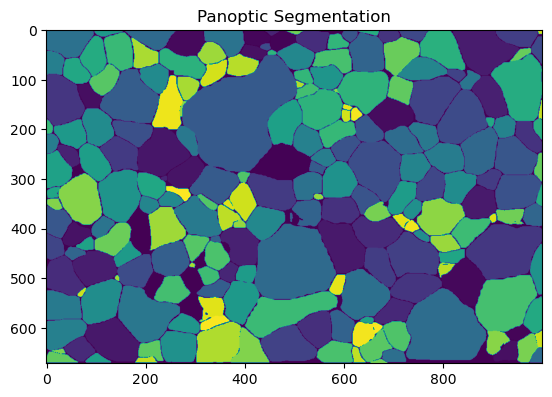

In [17]:
panoptic_seg = outputs['panoptic_seg'][0]
nonzero_indices = torch.nonzero(panoptic_seg)
if nonzero_indices.numel() > 0:
    print(f"Non-zero values found at indices: {nonzero_indices}")
    panoptic_seg_np = panoptic_seg.cpu().numpy()
    plt.imshow(panoptic_seg_np)
    plt.title('Panoptic Segmentation')
    plt.show()
else:
    print("No non-zero values found")

# Visualize Panoptic Segmentation on a Single Image

In [19]:
class CustomVisualizer(Visualizer):
# FROM DOCUMENTATION
# WE DON'T HAVE STUFF CLASSES SO SWAP THIS WITH THING CLASSES
    def draw_panoptic_seg_predictions(self, panoptic_seg, segments_info):
        panoptic_seg = panoptic_seg.numpy()
        for segment in segments_info:
            category_id = segment['category_id']
            mask = panoptic_seg == segment['id']
            
            # Generate a random color for each segment
            color = [random.random() for _ in range(3)]

            # Use thing_classes instead of stuff_classes
            if category_id < len(self.metadata.thing_classes):
                text = self.metadata.thing_classes[category_id]
            else:
                text = f"Unknown Class {category_id}"
            
            self.draw_binary_mask(
                mask,
                color=color,
                edge_color=(1, 1, 1),  
                text=text,
                alpha=0.7,
                area_threshold=0,
            )
        return self.output

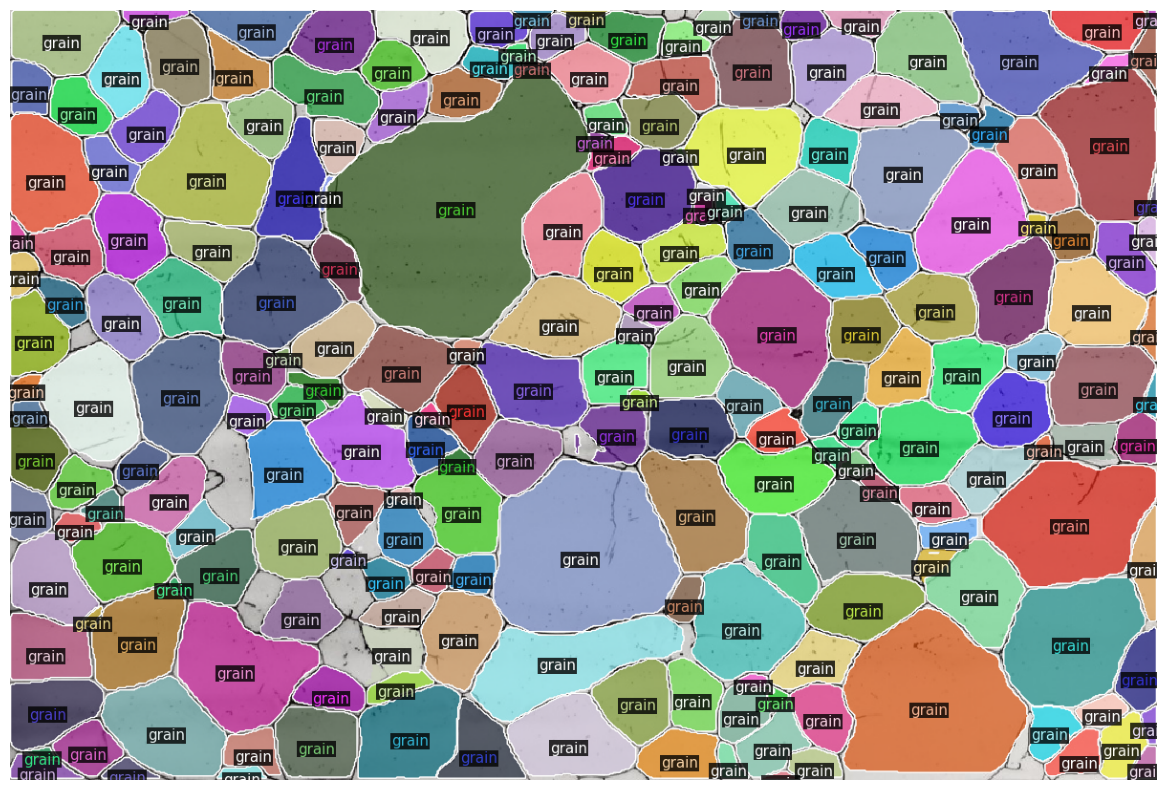

In [28]:
test_image_path = os.path.join(root_dir, "Stainless_316L_ASM_Annealed_NitricAcid.jpg")
im = cv2.imread(test_image_path)
outputs = predictor(im)
panoptic_seg, segments_info = outputs["panoptic_seg"]
v = CustomVisualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
v = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
# Save the result 
output_image = v.get_image()[:, :, ::-1]
output_path = os.path.join(root_dir, "output5k_batch_eq_11_lr_5e-4_gamma01_step2500.jpg")
cv2.imwrite(output_path, output_image)
# Panoptic segmentation visualization
plt.figure(figsize=(20,10))
plt.imshow(v.get_image())
plt.axis('off')
plt.show()

## Evaluation

In [22]:
# The following evaluation technique relies on a validation set being present, given the lack of image data I skipped this

evaluator = COCOEvaluator("panoptic_seg_uw_test_separated",output_dir="./output")
val_loader = build_detection_test_loader(cfg, "panoptic_seg_uw_test_separated")
print(inference_on_dataset(trainer.model,val_loader, evaluator))

[09/03 16:27:51 d2.data.datasets.coco]: Loaded 4 images in COCO format from /home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/test_panoptic_segmentation_output.json
[09/03 16:27:51 d2.data.datasets.coco]: Loaded 4 images with semantic segmentation from /home/computational/Desktop/detectron2_UW/detectron2/detectron2_scripts/test_images
[09/03 16:27:51 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   Grain    | 610          |
|            |              |
[09/03 16:27:51 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[09/03 16:27:51 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[09/03 16:27:51 d2.data.common]: Serializing 4 elements to byte tensors and concatenating them all ...
[09/03 16:27:51 d2.data.common]: Serial

In [ ]:
%load_ext tensorboard
%tensorboard --logdir output

### Saving Quantitative Outputs

In [ ]:
# assuming you haven't set up the following two variables below already
predictor = DefaultPredictor(cfg)
metadata = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])

# set up relative paths
current_dir = os.path.dirname(os.path.abspath('__file__'))
image_path = os.path.join(current_dir, "Stainless_316L_ASM_Annealed_NitricAcid.jpg")
output_dir = os.path.join(current_dir, "csv_out")
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

In [ ]:
image = cv2.imread(image_path)
file_name = "Stainless_316L_ASM_Annealed_NitricAcid.jpg"
outputs = predictor(image)

predictions_output = {
    "file_name": file_name,
    "file_location": str(image_path),
    "prediction": outputs
}

pickle_path = os.path.join(output_dir, "csv_out.pkl")
with open(pickle_path, "wb") as f:
    pickle.dump(predictions_output, f)

In [ ]:
boxes = outputs["instances"].pred_boxes.tensor.cpu().numpy()
masks = outputs["instances"].pred_masks.cpu().numpy().astype('uint8')

In [ ]:
contours = []
for mask in masks:
    contour, _ = cv2.findContours(mask, cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE)
    contours.append(contour[0])

In [ ]:
dataset = []
for i, box in enumerate(boxes):
    data = {
        "file_name": file_name,
        "file_location": str(image_path),
        "image_height": outputs["instances"].image_size[0],
        "image_width": outputs["instances"].image_size[1],
        "bounding_box": box,
        "mask": masks[i],
        "contours": contours[i]
    }
    contour_coords = np.squeeze(contours[i])
    if contour_coords.shape[0] >= 4:
        data["polygon"] = Polygon(contour_coords)
    else:
        data["polygon"] = None  # we ideally can filter these instances out later on while analyzing this data

    data["id"] = i
    dataset.append(data)
    
df = pd.DataFrame(dataset)
csv_df = df[["file_name", "id", "bounding_box", "polygon"]]
csv_df.to_csv("result_polygons_bboxes0918.csv", index=False)
print("Done")

### FOR MORE INFORMATION ON HOW SOME OF THIS CODE WORKS OR TO VIEW FAQs VISIT THIS GITHUB DISCUSSION FORUM (https://github.com/facebookresearch/detectron2/issues/1691)

#### If you think your COCO JSON formatting is off, check with the cell below

In [24]:
# https://learn.microsoft.com/en-us/azure/ai-services/computer-vision/how-to/coco-verification
# from cognitive_service_vision_model_customization_python_samples import check_coco_annotation_file, AnnotationKind, Purpose
# import pathlib
# import json

# coco_file_path = pathlib.Path("panoptic_segmentation_output.json")
# annotation_kind = AnnotationKind.OBJECT_DETECTION
# purpose = Purpose.TRAINING # or Purpose.EVALUATION

# check_coco_annotation_file(json.loads(coco_file_path.read_text()), annotation_kind, purpose)